### Imports

In [92]:
import os 

os.chdir("..")

In [99]:
!cd

C:\Users\hp\Documents\Python Scripts\Retail Analytics Copilot


In [107]:
from helper.clients import llm, retriever, db

ImportError: cannot import name 'db' from 'helper.clients' (c:\Users\hp\Documents\Python Scripts\Retail Analytics Copilot\helper\clients.py)

In [193]:
from agent.tools.sqlite_tool import SQLiteClient

db = SQLiteClient(r"data\database\northwind.db")

In [154]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    max_tokens=1024,
)

### Retrieval

In [ ]:
from pathlib import Path
from typing import List

from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_community.retrievers import BM25Retriever
from langchain_text_splitters import MarkdownHeaderTextSplitter

class BM25MarkdownRetriever:
    def __init__(self, directory: str, k: int = 4):
        self.directory = Path(directory)
        self.k = k
        self.docs = []
        self.chunks = []
        self.retriever = None

        self._load_documents()
        self._chunk_documents()
        self._build_retriever()

    def _load_documents(self):
        docs = []
        for path in self.directory.glob("**/*.md"):
            loader = TextLoader(str(path), encoding="utf-8")
            file_docs = loader.load()
            for d in file_docs:
                d.metadata["source"] = str(path)
            docs.extend(file_docs)

        self.docs = docs

    def _chunk_documents(self):
        docs_chunks = []

        headers_to_split_on = [
            ("#", "Header 1"),
            ("##", "Header 2"),
            ("###", "Header 3"),
        ]

        splitter = MarkdownHeaderTextSplitter(
            headers_to_split_on=headers_to_split_on,
            strip_headers=False
        )

        for doc_idx, doc in enumerate(self.docs):
            chunk_id = 0
            split_docs = splitter.split_text(doc.page_content)

            for chunk in split_docs:
                docs_chunks.append(
                    Document(
                        page_content=chunk.page_content,
                        metadata={
                            "source": doc.metadata.get("source"),
                            "parent_id": doc_idx,
                            "chunk_id": chunk_id,
                            "headers": chunk.metadata,  
                        },
                    )
                )
                chunk_id += 1

        self.chunks = docs_chunks

    def _build_retriever(self):
        retriever = BM25Retriever.from_documents(self.chunks)
        retriever.k = self.k
        self.retriever = retriever

    def query(self, query_str: str, k: int = None):
        if k is not None:
            self.retriever.k = k

        return self.retriever.get_relevant_documents(query_str)


In [ ]:
retrieval = BM25MarkdownRetriever("docs")

results = retrieval.query("what is AOV", 2)

for r in results:
    print(r)
    print("-" * 40)

page_content='# KPI Definitions  
## Average Order Value (AOV)  
- AOV = SUM(UnitPrice * Quantity * (1 - Discount)) / COUNT(DISTINCT OrderID)' metadata={'source': 'docs\\kpi_definitions.md', 'parent_id': 1, 'chunk_id': 0, 'headers': {'Header 1': 'KPI Definitions', 'Header 2': 'Average Order Value (AOV)'}}
----------------------------------------
page_content='## Gross Margin
- GM = SUM((UnitPrice - CostOfGoods) * Quantity * (1 - Discount))
- If cost is missing, approximate with category-level average (document your
approach).' metadata={'source': 'docs\\kpi_definitions.md', 'parent_id': 1, 'chunk_id': 1, 'headers': {'Header 1': 'KPI Definitions', 'Header 2': 'Gross Margin'}}
----------------------------------------


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from langchain_core.documents import Document

class MarkdownLoaderAndSplitter:
    def __init__(self, directory: str):
        self.directory = Path(directory)
        self.docs = []
        self.chunks = []

        self._load_documents()
        self._chunk_documents()

    def _load_documents(self):
        docs = []
        for path in self.directory.glob("**/*.md"):
            loader = TextLoader(str(path), encoding="utf-8")
            file_docs = loader.load()
            for d in file_docs:
                d.metadata["source"] = str(path)
            docs.extend(file_docs)

        self.docs = docs

    def _chunk_documents(self):
        docs_chunks = []

        headers_to_split_on = [
            ("#", "Header 1"),
            ("##", "Header 2"),
            ("###", "Header 3"),
        ]

        splitter = MarkdownHeaderTextSplitter(
            headers_to_split_on=headers_to_split_on,
            strip_headers=False
        )

        for doc_idx, doc in enumerate(self.docs):
            chunk_id = 0
            split_docs = splitter.split_text(doc.page_content)

            for chunk in split_docs:
                docs_chunks.append(
                    Document(
                        page_content=chunk.page_content,
                        metadata={
                            "source": doc.metadata.get("source"),
                            "parent_id": doc_idx,
                            "chunk_id": chunk_id,
                            "headers": chunk.metadata,  
                        },
                    )
                )
                chunk_id += 1

        self.chunks = docs_chunks

class TfidfRetriever:
    def __init__(self, documents, k=5):
        """
        documents: list of langchain Documents
        """
        self.docs = documents
        self.k = k
        self.texts = [doc.page_content for doc in documents]

        # Build TF-IDF matrix
        self.vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.vectorizer.fit_transform(self.texts)

    def query(self, query_str):
        # Transform query into TF-IDF vector
        query_vec = self.vectorizer.transform([query_str])
        # Compute cosine similarity
        scores = cosine_similarity(query_vec, self.tfidf_matrix)[0]

        # Rank top-k
        ranked_idx = scores.argsort()[::-1][:self.k]

        results = []
        for idx in ranked_idx:
            doc = self.docs[idx]
            doc.metadata["score"] = float(scores[idx])
            results.append(doc)

        return results


In [51]:
docs = [
    Document(page_content="The sky is blue", metadata={"source": "doc1"}),
    Document(page_content="The sun is bright", metadata={"source": "doc2"}),
    Document(page_content="We can see the shining sun", metadata={"source": "doc3"}),
]

retriever = TfidfRetriever(docs, k=2)
results = retriever.query("bright sun")
print(results)
for r in results:
    print(r.metadata["source"], r.metadata["score"], r.page_content)


[Document(metadata={'source': 'doc2', 'score': 0.7936889095430353}, page_content='The sun is bright'), Document(metadata={'source': 'doc3', 'score': 0.20740448114419505}, page_content='We can see the shining sun')]
doc2 0.7936889095430353 The sun is bright
doc3 0.20740448114419505 We can see the shining sun


In [63]:
docs = MarkdownLoaderAndSplitter("docs")

retriever = TfidfRetriever(docs.chunks, k=20)
results = retriever.query("what is average order value ?")

for r in results:
    print(r.metadata)
    print(r.page_content)
    print("-" * 40)

{'source': 'docs\\kpi_definitions.md', 'parent_id': 1, 'chunk_id': 0, 'headers': {'Header 1': 'KPI Definitions', 'Header 2': 'Average Order Value (AOV)'}, 'score': 0.36797614416716895}
# KPI Definitions  
## Average Order Value (AOV)  
- AOV = SUM(UnitPrice * Quantity * (1 - Discount)) / COUNT(DISTINCT OrderID)
----------------------------------------
{'source': 'docs\\kpi_definitions.md', 'parent_id': 1, 'chunk_id': 1, 'headers': {'Header 1': 'KPI Definitions', 'Header 2': 'Gross Margin'}, 'score': 0.20366129262305704}
## Gross Margin
- GM = SUM((UnitPrice - CostOfGoods) * Quantity * (1 - Discount))
- If cost is missing, approximate with category-level average (document your
approach).
----------------------------------------
{'source': 'docs\\product_policy.md', 'parent_id': 3, 'chunk_id': 0, 'headers': {'Header 1': 'Returns & Policy'}, 'score': 0.0}
# Returns & Policy
- Perishables (Produce, Seafood, Dairy): 3–7 days.
- Beverages unopened: 14 days; opened: no returns.
- Non-perishab

### SQL Tools

In [ ]:
import sqlite3
import logging

logging.basicConfig(
    filename="logs/agentlog.log",
    format='%(asctime)s %(levelname)s %(message)s',
    filemode='a',
    level=logging.INFO)

logger = logging.getLogger()

class SQLiteClient:
    def __init__(self, db_name):
        self.db_name = db_name
        self.conn = None
        self.cursor = None

    def connect(self):
        try:
            self.conn = sqlite3.connect(self.db_name)
            self.cursor = self.conn.cursor()
            logger.info(f"Connected to {self.db_name}")
        except sqlite3.Error as e:
            print(f"Error connecting to database: {e}")

    def disconnect(self):
        if self.conn:
            self.conn.close()
            logger.info(f"Disconnected from {self.db_name}")

    def fetch_all(self, table_name):
        try:
            self.cursor.execute(f"SELECT * FROM {table_name}")
            rows = self.cursor
            return rows
        except sqlite3.Error as e:
            logger.error(f"Error fetching data: {e}")
            return []

    def extract_schema(self, table_name = None) -> str:
        if isinstance(table_name, str):
            tables = [table_name]
        elif isinstance(table_name, list):
            tables = table_name
        else:
            tables = self.cursor.execute(
                "SELECT name FROM sqlite_master WHERE type='table';"
            ).fetchall()
            
        schema_text = ""

        for t in tables:
            cols = self.cursor.execute(f"PRAGMA table_info('{t}');").fetchall()
            schema_text += f"\nTable Name: **{t}**\n"
            for col in cols:
                cid, name, ctype, notnull, dflt, pk = col
                schema_text += f"  - {name} {ctype}\n"
        return schema_text 

    def execute_query(self, query, params=(), return_with_columns_names=False):
        """
        Executes a custom SQL query.
        """
        try:
            self.cursor.execute(query, params, )
            self.conn.commit()
            rows = self.cursor.fetchall()
        except sqlite3.Error as e:
            logger.error(f"Error executing query: {e}")
            return [], [], e
        
        column_names = [description[0] for description in self.cursor.description]
        if return_with_columns_names:
            results_with_names = [
                {col_name: row[i] for i, col_name in enumerate(column_names)}
                for row in rows
            ]
            return results_with_names, column_names
        return rows, column_names, None
    
if __name__ == "__main__":
    db = SQLiteClient(r"data\database\northwind.db")
    try:
        db.connect()
        table_names = "Categories"
        table_names = ["Orders", "Order Details", "Products"]
        print( db.extract_schema(table_names) )
        print( db.execute_query("SELECT CategoryID, CategoryName, Description FROM Categories LIMIT 2", return_with_columns_names=True) )
    except Exception as e:
        print(e)
    finally:
        db.disconnect()


Table Name: **Orders**
  - OrderID INTEGER
  - CustomerID TEXT
  - EmployeeID INTEGER
  - OrderDate DATETIME
  - RequiredDate DATETIME
  - ShippedDate DATETIME
  - ShipVia INTEGER
  - Freight NUMERIC
  - ShipName TEXT
  - ShipAddress TEXT
  - ShipCity TEXT
  - ShipRegion TEXT
  - ShipPostalCode TEXT
  - ShipCountry TEXT

Table Name: **Order Details**
  - OrderID INTEGER
  - ProductID INTEGER
  - UnitPrice NUMERIC
  - Quantity INTEGER
  - Discount REAL

Table Name: **Products**
  - ProductID INTEGER
  - ProductName TEXT
  - SupplierID INTEGER
  - CategoryID INTEGER
  - QuantityPerUnit TEXT
  - UnitPrice NUMERIC
  - UnitsInStock INTEGER
  - UnitsOnOrder INTEGER
  - ReorderLevel INTEGER
  - Discontinued TEXT

([{'CategoryID': 1, 'CategoryName': 'Beverages', 'Description': 'Soft drinks, coffees, teas, beers, and ales'}, {'CategoryID': 2, 'CategoryName': 'Condiments', 'Description': 'Sweet and savory sauces, relishes, spreads, and seasonings'}], ['CategoryID', 'CategoryName', 'Description'

### Prompts

In [2]:
### Prompts.py

from langchain_core.prompts import PromptTemplate

ROUTER_PROMPT = PromptTemplate.from_template("""
You are a routing classifier. Your job is to choose EXACTLY one of the following options:

- rag
- sql
- hybrid

### Routing Logic

Choose **rag** when:
- The user asks about information that is *not stored in structured tables*, such as:
  - company policies (return policy, refund policy, warranty policy)
  - KPI definitions or formulas
  - product catalog descriptions or product metadata
  - calendars, schedules, holidays, timelines
  - any conceptual, descriptive, or unstructured text found only in documents

Choose **sql** when:
- The user requests information that comes directly from structured database tables, such as:
  - sales data, revenue, counts, aggregated metrics
  - filtering by dates, product names, categories, customers
  - retrieving raw values from the DB
- No external text, policy, description, calendar logic, or KPI formula is needed.

Choose **hybrid** when:
- The task requires BOTH:
  1. Retrieving definitions, formulas, explanations, product details, return policy, OR calendar/date logic from documents (RAG)
  2. AND applying them to structured data using SQL
- Examples:
  - Using a KPI formula found in documents and computing it using SQL table data
  - Interpreting product details or policy rules from documents, then using SQL to retrieve supporting numbers
  - Understanding calendar context (e.g., holidays, fiscal periods) from documents, then querying the DB for data within those derived date ranges

### Output rules
- Output ONLY one word: "rag", "sql", or "hybrid".
- No explanation. No punctuation. No extra text.

User Query:
{query}

Your output:
""")
PLANNER_PROMPT = PromptTemplate.from_template("""
You are a constraint extractor.

Given the retrieved context chunks, extract any constraints that could be used for planning a query.

Extract:
- date ranges (e.g., "last 7 days", "2023-01 to 2023-03")
- KPIs or metrics formulas (e.g., "revenue", "conversion rate", "sum(sales)")
- categories or labels (e.g., "product A", "region = Europe")
- entities (company names, product names, user IDs, etc.)

Return JSON following the exact schema.

Retrieved Chunks:
{chunks}
""")

SQL_PROMPT = PromptTemplate.from_template("""
You are an expert SQL generator for **SQLite**. 
Your job is to produce a **single valid SELECT query** that answers the user question.

You will receive:
- The **database schema**
- Extracted **constraints**
- The **user question**
- (Optional) An **error message** from the previous failed query
- (Optional) The **previous SQL query** that caused the error

Follow the rules carefully.

========================================
### SCHEMA
{schema}

### CONSTRAINTS (date ranges, categories, KPIs, entities)
{constraints}

### USER QUESTION
{question}

### PREVIOUS SQL (optional)
{previous_sql}

### ERROR MESSAGE (optional)
{error}
========================================

### RULES
1. **Output ONLY valid SQLite SQL** — no text, no explanations.
2. Always return **one SELECT statement**, never multiple.
3. Use only tables/columns that exist in the schema.
4. Apply all constraints (filters, date ranges, categories, entities).
5. If KPI metrics exist, compute them inside the SQL using the formula.
6. If this is a retry:
   - **Fix the previous SQL instead of starting from scratch.**
   - The error message describes exactly what to correct.
   - Maintain user intent.
7. Never hallucinate columns or tables.

### YOUR TASK
Generate the corrected SQL query (or the initial SQL if no error exists).
""")

SYNTH_PROMPT = PromptTemplate.from_template("""
You are a synthesizer that must combine RAG results, SQL results, and user instructions.

### Requirements
- Produce a FINAL ANSWER in the requested format: "{format_hint}"
- Use both RAG and SQL results when relevant
- EXPLANATION: max 2 sentences ONLY

### Inputs
Question:
{question}

RAG Output:
{rag_output}

SQL Output:
{sql_output}

### Output JSON schema:
- final_answer: string
- explanation: <= 2 sentences
""")


### Models

In [ ]:
### models.py
from typing import Literal, TypedDict, Optional, List, Dict, Any
from pydantic import BaseModel

class AgentState(TypedDict):
    id: str
    question: str
    table_names: List[str]
    route: Optional[Literal["rag", "sql", "hybrid"]]
    retrieved_docs: List[Dict[str, Any]]
    constraints: Dict[str, Any]
    sql_query: Optional[str]
    sql_result: Optional[Dict[str, Any]]
    final_answer: Optional[str]
    error: Optional[str]
    attempt_count: int
    format_hint: Optional[str]
    citations: List[str]
    confidence: float
    explanation: str

class RouterState(BaseModel):
    route: Literal["rag", "sql", "hybrid"]

class ConstraintPlan(BaseModel):
    date_ranges: Optional[List[str]] = None
    kpis: Optional[List[str]] = None
    categories: Optional[List[str]] = None
    
class SQLGeneration(BaseModel):
    sql: str

class SQLExecutionResult(BaseModel):
    columns: Optional[List[str]] = None
    rows: Optional[List[List]] = None
    error: Optional[str] = None

class SynthesizerOutput(BaseModel):
    final_answer: str
    explanation: str

### Graph Agent 

In [238]:
### graph.py
import logging
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableConfig

logging.basicConfig(
    filename="logs/agentlog.log",
    format='%(asctime)s %(levelname)s %(message)s',
    filemode='w',
    level=logging.INFO)

logger = logging.getLogger()

def router_node(state: AgentState, config: RunnableConfig) -> AgentState:
    question = state["question"]
    llm = config["configurable"].get("llm")

    router_chain = ROUTER_PROMPT | llm.with_structured_output(RouterState)
    out = router_chain.invoke(question)

    state["route"] = out.route
    logger.info(f"router_node: {out=}")
    return state

def retriever_node(state: AgentState, config: RunnableConfig) -> AgentState:
    question = state["question"]
    retriever = config["configurable"].get("retriever") 

    state["retrieved_docs"] = retriever.query(question, 4)
    logger.info(f"retriever_node: {state["retrieved_docs"]=}")
    return state

def planner_node(state: AgentState, config: RunnableConfig) -> AgentState:
    chunks_text = "\n\n".join([doc.page_content for doc in state["retrieved_docs"]])
    llm = config["configurable"].get("llm")

    planner_chain = PLANNER_PROMPT | llm.with_structured_output(ConstraintPlan)
    constraints = planner_chain.invoke({"chunks": chunks_text})
    
    state["constraints"] = constraints.model_dump()
    logger.info(f"retriever_node: {state["constraints"]=}")
    return state

def nl_to_sql_node(state: AgentState, config: RunnableConfig) -> AgentState:
    question = state["question"]
    constraints = state.get("constraints", {})
    sql_error = state.get("sql_result", {}).get("error")
    sql_query = state.get("sql_query", "")

    llm = config["configurable"].get("llm")
    db = config["configurable"].get("db")
    
    try:
        db.connect()
        schema_str = db.extract_schema(state["table_names"])
    except Exception as e:
        logger.error(f"nl_to_sql_node: {e}")
    finally:
        db.disconnect()

    nl_to_sql_chain = SQL_PROMPT | llm.with_structured_output(SQLGeneration)
    result = nl_to_sql_chain.invoke({
        "schema": schema_str,
        "constraints": constraints,
        "question": question,
        "error": sql_error,
        "previous_sql": sql_query
    })

    state["sql_query"] = result.sql
    logger.info(f"nl_to_sql_node: {state["sql_query"]=}")
    return state

def sql_executor_node(state: AgentState, config: RunnableConfig) -> AgentState:
    sql_query = state["sql_query"]
    db = config["configurable"].get("db")

    try:
        db.connect()
        rows, col_names, error = db.execute_query(sql_query)
        result = SQLExecutionResult(columns=col_names, rows=rows, error=str(error))
    except Exception as e:
        logger.error(f"sql_executor_node: {e}")
        result = SQLExecutionResult(columns=None, rows=None, error=str(e))
    finally:
        db.disconnect()
        state["sql_result"] = result.model_dump()
    logger.info(f"sql_executor_node: {state["sql_result"]=}")
    return state

def retry_counter_node(state: AgentState) -> AgentState:
    state["attempt_count"] += 1
    return state

def Synthesizer_node(state: AgentState, config: RunnableConfig) -> AgentState:
    chunks = state.get("retrieved_docs", [])
    llm = config["configurable"].get("llm")
    synth_chain = SYNTH_PROMPT | llm.with_structured_output(SynthesizerOutput)

    result: SynthesizerOutput = synth_chain.invoke({
        "format_hint": state["format_hint"],
        "question": state["question"],
        "rag_output": "\n\n".join(doc.page_content for doc in chunks),
        "sql_output": state.get("sql_result", {}),
    })

    state["final_answer"] = result.final_answer
    state["explanation"] = result.explanation
    logger.info(f"Synthesizer_node: {state["final_answer"]=}")
    return state

def format_output(state: AgentState, config: RunnableConfig) -> AgentState:
    state["citations"] = []
    rag_score = 1
    sql_score = 1
    rows_score = 1

    if state["route"] in ["rag", "hybrid"] and state.get("retrieved_docs", []):
        chunks = state.get("retrieved_docs", [])
        state["citations"] += [f"{chunk.metadata["source"]}:chunk_{chunk.metadata["chunk_id"]}" for chunk in chunks] 
        rag_score = sum([chunk.metadata["score"] for chunk in chunks]) / len(chunks)

    if state["route"] in ["sql", "hybrid"] and state["table_names"]:
        state["citations"] += state["table_names"]
        sql_score = 1 if not state.get("sql_result", {}).get("error") else 0
        rows_score = 1 if state["sql_result"].get("rows", {}) else 0

    state["confidence"] = round((rag_score + sql_score + rows_score) / 3, 3)
    return state

graph_agent = StateGraph(AgentState)

graph_agent.add_node("router", router_node)
graph_agent.add_node("retriever", retriever_node)
graph_agent.add_node("planner", planner_node)
graph_agent.add_node("nl_to_sql", nl_to_sql_node)
graph_agent.add_node("sql_executor", sql_executor_node)
graph_agent.add_node("retry_counter", retry_counter_node)
graph_agent.add_node("Synthesizer", Synthesizer_node)
graph_agent.add_node("format_output", format_output)

graph_agent.set_entry_point("router")

graph_agent.add_conditional_edges(
    "router",
    lambda x: "rag" if x["route"] in ["rag", "hybrid"] else "sql",
    {
        "rag": "retriever",
        "sql": "nl_to_sql"
    }
)

graph_agent.add_conditional_edges(
    "retriever",
    lambda x: "sql" if x["route"] in ["sql", "hybrid"] else "end",
    {
        "sql": "planner",
        "end": "Synthesizer"
    }
)

graph_agent.add_edge("planner", "nl_to_sql")
graph_agent.add_edge("nl_to_sql", "sql_executor")
graph_agent.add_edge("sql_executor", "retry_counter")

def sql_retry(state: AgentState) -> str:
    sql_rows = state["sql_result"].get("rows", [])
    if sql_rows:
        return "success"
    elif state["attempt_count"] <= 2:
        return "retry"
    return "fallback"

graph_agent.add_conditional_edges(
    "retry_counter",
    sql_retry,
    {
        "success": "Synthesizer",
        "retry": "nl_to_sql",
        "fallback": "Synthesizer"
    }
)

graph_agent.add_edge("Synthesizer", "format_output")
graph_agent.add_edge("format_output", END)

agent = graph_agent.compile()




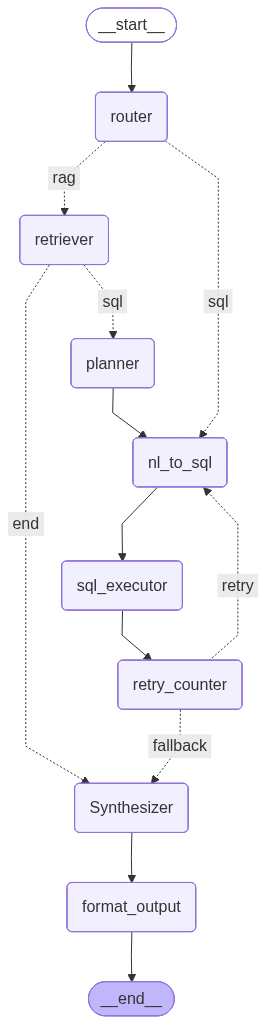

In [173]:
from IPython.display import Image

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [223]:
config = {
    "configurable": {
		"llm": llm, 
		"retriever": retriever, 
		"db": db
    },
    "recursion_limit": 15
}

input = {
    "id": "rag_policy_beverages_return_days",
    "question": "According to the product policy, what is the return window (days) for unopened Beverages? Return an integer.",
    "format_hint": "int",
    "table_names": ["demo_orders", "demo_order_details", "demo_products"],
    "attempt_count": 0
}

out = agent.invoke(input, config)
out

{'id': 'rag_policy_beverages_return_days',
 'question': 'According to the product policy, what is the return window (days) for unopened Beverages? Return an integer.',
 'table_names': ['demo_orders', 'demo_order_details', 'demo_products'],
 'route': 'rag',
 'retrieved_docs': [Document(metadata={'source': 'docs\\product_policy.md', 'parent_id': 3, 'chunk_id': 0, 'headers': {'Header 1': 'Returns & Policy'}, 'score': 0.3407}, page_content='# Returns & Policy\n- Perishables (Produce, Seafood, Dairy): 3–7 days.\n- Beverages unopened: 14 days; opened: no returns.\n- Non-perishables: 30 days.'),
  Document(metadata={'source': 'docs\\catalog.md', 'parent_id': 0, 'chunk_id': 0, 'headers': {'Header 1': 'Catalog Snapshot'}, 'score': 0.1934}, page_content='# Catalog Snapshot\n- Categories include Beverages, Condiments, Confections, Dairy Products,\nGrains/Cereals, Meat/Poultry, Produce, Seafood.\n- Products map to categories as in the Northwind DB.'),
  Document(metadata={'source': 'docs\\marketin

In [233]:
config = {
    "configurable": {
		"llm": llm, 
		"retriever": retriever, 
		"db": db
    },
    "recursion_limit": 15
}

input = {
	"id": "sql_top3_products_by_revenue_alltime",
	"question": "Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].",
	"format_hint": "list[{product:str, revenue:float}]",
    "table_names": ["demo_orders", "demo_order_details", "demo_products"],
    "attempt_count": 0
}

out = agent.invoke(input, config)
out

{'id': 'sql_top3_products_by_revenue_alltime', 'question': 'Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].', 'table_names': ['demo_orders', 'demo_order_details', 'demo_products'], 'route': 'sql', 'sql_query': 'SELECT p.ProductName, SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS revenue FROM demo_order_details od INNER JOIN demo_products p ON od.ProductID = p.ProductID GROUP BY p.ProductName ORDER BY revenue DESC LIMIT 3', 'sql_result': {'columns': ['ProductName', 'revenue'], 'rows': [['Côte de Blaye', 53265895.235], ['Thüringer Rostbratwurst', 24623469.232], ['Mishi Kobe Niku', 19423037.5]], 'error': 'None'}, 'attempt_count': 1, 'format_hint': 'list[{product:str, revenue:float}]'}
None


{'id': 'sql_top3_products_by_revenue_alltime',
 'question': 'Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].',
 'table_names': ['demo_orders', 'demo_order_details', 'demo_products'],
 'route': 'sql',
 'sql_query': 'SELECT p.ProductName, SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS revenue FROM demo_order_details od INNER JOIN demo_products p ON od.ProductID = p.ProductID GROUP BY p.ProductName ORDER BY revenue DESC LIMIT 3',
 'sql_result': {'columns': ['ProductName', 'revenue'],
  'rows': [['Côte de Blaye', 53265895.235],
   ['Thüringer Rostbratwurst', 24623469.232],
   ['Mishi Kobe Niku', 19423037.5]],
  'error': 'None'},
 'final_answer': 'list[{product: Côte de Blaye, revenue: 53265895.235}, {product: Thüringer Rostbratwurst, revenue: 24623469.232}, {product: Mishi Kobe Niku, revenue: 19423037.5}]',
 'attempt_count': 1,
 'format_hint': 'list[{product:str, revenue:float}]',

In [242]:
config = {
    "configurable": {
		"llm": llm, 
		"retriever": retriever, 
		"db": db
    },
    "recursion_limit": 15
}

input = {
	"id": "hybrid_aov_winter_1997",
	"question": "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.",
	"format_hint": "float",
    "table_names": ["demo_orders", "demo_order_details", "demo_products"],
    "attempt_count": 0
}

out = agent.invoke(input, config)
out

{'id': 'hybrid_aov_winter_1997',
 'question': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.",
 'table_names': ['demo_orders', 'demo_order_details', 'demo_products'],
 'route': 'hybrid',
 'retrieved_docs': [Document(metadata={'source': 'docs\\kpi_definitions.md', 'parent_id': 1, 'chunk_id': 0, 'headers': {'Header 1': 'KPI Definitions', 'Header 2': 'Average Order Value (AOV)'}, 'score': 0.3649}, page_content='# KPI Definitions  \n## Average Order Value (AOV)  \n- AOV = SUM(UnitPrice * Quantity * (1 - Discount)) / COUNT(DISTINCT OrderID)'),
  Document(metadata={'source': 'docs\\marketing_calendar.md', 'parent_id': 2, 'chunk_id': 1, 'headers': {'Header 1': 'Northwind Marketing Calendar (1997)', 'Header 2': 'Winter Classics 1997'}, 'score': 0.2335}, page_content='## Winter Classics 1997\n- Dates: 1997-12-01 to 1997-12-31\n- Notes: Push Dairy Products and Confections for holiday gifting.'),
 

In [170]:
router_node(input, config)

{'id': 'hybrid_top_category_qty_summer_1997',
 'question': "During 'Summer Beverages 1997' as defined in the marketing calendar, which product category had the highest total quantity sold? Return {category:str, quantity:int}.",
 'format_hint': '{category:str, quantity:int}',
 'table_names': ['Orders', 'Order Details', 'Products'],
 'attempt_count': 0,
 'route': 'sql'}

In [240]:
questions = [
    "According to the product policy, what is the return window (days) for unopened Beverages? Return an integer.",
	"During 'Summer Beverages 1997' as defined in the marketing calendar, which product category had the highest total quantity sold? Return {category:str, quantity:int}.",
    "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.",
	"Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].",
	"Total revenue from the 'Beverages' category during 'Summer Beverages 1997' dates. Return a float rounded to 2 decimals.",
	"Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.",
]

for q in questions:
	input["question"] = q
	out = router_node(input, config)
	print(out["route"])

rag
sql
hybrid
sql
sql
hybrid


### DSPy

In [6]:
ROUTER_PROMPT_TEMPLATE = """
You are a routing classifier. Your job is to choose EXACTLY one of the following options:

- rag
- sql
- hybrid

### Routing Logic

Choose **rag** when:
- The user asks about information that is *not stored in structured tables*, such as:
  - company policies (return policy, refund policy, warranty policy)
  - KPI definitions or formulas
  - product catalog descriptions or product metadata
  - calendars, schedules, holidays, timelines
  - any conceptual, descriptive, or unstructured text found only in documents

Choose **sql** when:
- The user requests information that comes directly from structured database tables, such as:
  - sales data, revenue, counts, aggregated metrics
  - filtering by dates, product names, categories, customers
  - retrieving raw values from the DB
- No external text, policy, description, calendar logic, or KPI formula is needed.

Choose **hybrid** when:
- The task requires BOTH:
  1. Retrieving definitions, formulas, explanations, product details, return policy, OR calendar/date logic from documents (RAG)
  2. AND applying them to structured data using SQL
- Examples:
  - Using a KPI formula found in documents and computing it using SQL table data
  - Interpreting product details or policy rules from documents, then using SQL to retrieve supporting numbers
  - Understanding calendar context (e.g., holidays, fiscal periods) from documents, then querying the DB for data within those derived date ranges

### Output rules
- Output ONLY one word: "rag", "sql", or "hybrid".
- No explanation. No punctuation. No extra text.

User Query:
{query}

Your output:
"""

In [75]:
import os 
import dspy
from dspy.teleprompt import MIPROv2


class RouteSignature(dspy.Signature):
    query = dspy.InputField()
    route = dspy.OutputField()


class RouterModule(dspy.Module):
    def __init__(self):
        super().__init__()

        base_prompt = ROUTER_PROMPT_TEMPLATE

        self.classifier = dspy.Predict(
            RouteSignature,
            instructions=base_prompt
        )

    def forward(self, query):
        return self.classifier(query=query).route
    
# Inference model: run locally on your machine
infer_lm = dspy.LM(
    model=f"ollama_chat/{os.getenv("OLLAMA_LLM_MODEL_ID")}",                    
    api_base="http://localhost:11434",
    api_key="",
)

# Optimization model: strong Groq model
opt_lm = dspy.LM(
    model=os.getenv("GROQ_LLM_MODEL_ID"),
    api_base="https://api.groq.com/openai/v1",
    api_key=os.getenv("GROQ_API_KEY"),
)

optimizer = MIPROv2(
    metric=lambda example, pred: example.route.lower() == pred.route.lower(),
    auto="light",
    # num_candidates=4,
    prompt_model=opt_lm,
    task_model=opt_lm,
)


In [73]:
infer_lm("hi, how are yuou")

["I'm doing well, thanks for asking! As a large language model, I don't experience feelings in the same way humans do, but I’m functioning properly and ready to help you with whatever you need. 😊 \n\nHow about you? How’s your day going?"]

In [42]:
trainset = [
    {"query": "According to the product policy, what is the return window (days) for unopened Beverages? Return an integer.", "route": "rag"},
    {"query": "During 'Summer Beverages 1997' as defined in the marketing calendar, which product category had the highest total quantity sold? Return {category:str, quantity:int}.", "route": "hybrid"},
    {"query": "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", "route": "hybrid"},
    {"query": "Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].", "route": "sql"},
    {"query": "Total revenue from the 'Beverages' category during 'Summer Beverages 1997' dates. Return a float rounded to 2 decimals.", "route": "hybrid"},
    {"query": "Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.", "route": "hybrid"},
]

trainset_dspy = []

for i in trainset:
    trainset_dspy.append(
        dspy.Example(query=i.get("query"), route=i.get("route")).with_inputs("query"),
    )

trainset_dspy

[Example({'query': 'According to the product policy, what is the return window (days) for unopened Beverages? Return an integer.', 'route': 'rag'}) (input_keys={'query'}),
 Example({'query': "During 'Summer Beverages 1997' as defined in the marketing calendar, which product category had the highest total quantity sold? Return {category:str, quantity:int}.", 'route': 'hybrid'}) (input_keys={'query'}),
 Example({'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}) (input_keys={'query'}),
 Example({'query': 'Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].', 'route': 'sql'}) (input_keys={'query'}),
 Example({'query': "Total revenue from the 'Beverages' category during 'Summer Beverages 1997' dates. Return a float rounded to 2 decimals.", 'route': 'hybrid'}) (input_k

In [82]:
compiled_router = optimizer.compile(
    RouterModule(),
    trainset=trainset,
)

2025/11/29 19:08:02 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: False
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 4

2025/11/29 19:08:02 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/11/29 19:08:02 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/11/29 19:08:02 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


  0%|          | 0/2 [00:00<?, ?it/s]2025/11/29 19:08:02 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'query': 'According to the product policy, what is the return window (days) for unopened Beverages? Return an integer.', 'route': 'rag'} with <function <lambda> at 0x000001C013BBB7E0> due to 'dict' object has no attribute 'inputs'.
2025/11/29 19:08:02 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'query': "During 'Summer Beverages 1997' as defined in the marketing calendar, which product category had the highest total quantity sold? Return {category:str, quantity:int}.", 'route': 'hybrid'} with <function <lambda> at 0x000001C013BBB7E0> due to 'dict' object has no attribute 'inputs'.
100%|██████████| 2/2 [00:00<00:00, 501.11it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/6


  0%|          | 0/2 [00:00<?, ?it/s]2025/11/29 19:08:02 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'query': "During 'Summer Beverages 1997' as defined in the marketing calendar, which product category had the highest total quantity sold? Return {category:str, quantity:int}.", 'route': 'hybrid'} with <function <lambda> at 0x000001C013BBB7E0> due to 'dict' object has no attribute 'inputs'.
2025/11/29 19:08:02 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'query': 'According to the product policy, what is the return window (days) for unopened Beverages? Return an integer.', 'route': 'rag'} with <function <lambda> at 0x000001C013BBB7E0> due to 'dict' object has no attribute 'inputs'.
100%|██████████| 2/2 [00:00<00:00, 500.51it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/6


  0%|          | 0/2 [00:00<?, ?it/s]2025/11/29 19:08:02 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'query': "During 'Summer Beverages 1997' as defined in the marketing calendar, which product category had the highest total quantity sold? Return {category:str, quantity:int}.", 'route': 'hybrid'} with <function <lambda> at 0x000001C013BBB7E0> due to 'dict' object has no attribute 'inputs'.
2025/11/29 19:08:02 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'query': 'According to the product policy, what is the return window (days) for unopened Beverages? Return an integer.', 'route': 'rag'} with <function <lambda> at 0x000001C013BBB7E0> due to 'dict' object has no attribute 'inputs'.
100%|██████████| 2/2 [00:00<00:00, 400.83it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/6


  0%|          | 0/2 [00:00<?, ?it/s]2025/11/29 19:08:02 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'query': 'According to the product policy, what is the return window (days) for unopened Beverages? Return an integer.', 'route': 'rag'} with <function <lambda> at 0x000001C013BBB7E0> due to 'dict' object has no attribute 'inputs'.
2025/11/29 19:08:03 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'query': "During 'Summer Beverages 1997' as defined in the marketing calendar, which product category had the highest total quantity sold? Return {category:str, quantity:int}.", 'route': 'hybrid'} with <function <lambda> at 0x000001C013BBB7E0> due to 'dict' object has no attribute 'inputs'.
100%|██████████| 2/2 [00:00<00:00, 500.19it/s]
2025/11/29 19:08:03 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/11/29 19:08:03 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from t

Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Given the fields `query`, produce the fields `route`.

2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: 1: In a high-stakes emergency customer support scenario, where a customer is on the verge of abandoning their online shopping cart due to a navigation error, use the query to generate the most relevant and efficient route to guide the customer to the final checkout page, ensuring a seamless and stress-free shopping experience while maximizing the likelihood of the customer completing their purchase.

2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: 2: Given the context of a business dataset related to e-commerce or retail, and a text routing or classification task, I propose the following instruction to prompt a Language Model to better solve the task:

"Please classify the input query `query` into

Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 444.48it/s]

2025/11/29 19:08:04 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 0.0

c:\Users\hp\Documents\Python Scripts\Retail Analytics Copilot\env\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 10 =====
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': "Total revenue from the 'Beverages' category during

2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 266.61it/s]

2025/11/29 19:08:04 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0]
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 10 =====
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:04 ERROR dspy.utils.parallel

2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].', 'route': 'sql'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 500.05it/s]

2025/11/29 19:08:04 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0, 0.0]
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 10 =====
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:04 ERROR dspy.utils.par

2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].', 'route': 'sql'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


  0%|          | 0/4 [00:00<?, ?it/s]

2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 444.50it/s]

2025/11/29 19:08:04 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0, 0.0, 0.0]
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 10 =====
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:04 ERROR dspy.util

2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 400.08it/s]

2025/11/29 19:08:04 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0]
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 10 =====
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:04 ERROR dspy

2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].', 'route': 'sql'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


  0%|          | 0/4 [00:00<?, ?it/s]

2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 571.24it/s]

2025/11/29 19:08:04 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ========================




2025/11/29 19:08:04 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 10 =====
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': "Total revenue from the 'Beverages' category during 'Summer Beverages 1997' dates. Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': 'Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].', 'route': 's

  0%|          | 0/4 [00:00<?, ?it/s]

2025/11/29 19:08:04 ERROR dspy.utils.parallelizer: Error for {'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 285.76it/s]

2025/11/29 19:08:05 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 8 / 10 =====
2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': "Total revenue from the 'Beverages' category during 'Summer Beverages 1997' dates. Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'q

  0%|          | 0/4 [00:00<?, ?it/s]

2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 500.07it/s]

2025/11/29 19:08:05 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 9 / 10 =====
2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:0


  0%|          | 0/4 [00:00<?, ?it/s]

2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 499.99it/s]

2025/11/29 19:08:05 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].


2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 10 / 10 =====
2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': "Total revenue from the 'Beverages' category during 'Summer Beverages 1997' dates. Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attri

Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 285.73it/s]

2025/11/29 19:08:05 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 11 / 10 =====
2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': 'Per the KPI definition of gross margin, who was the top customer by gross margin in 1997? Assume CostOfGoods is approximated by 70% of UnitPrice if not available. Return {customer:str, margin:float}.', 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.
202

2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': 'Top 3 products by total revenue all-time. Revenue uses Order Details: SUM(UnitPrice*Quantity*(1-Discount)). Return list[{product:str, revenue:float}].', 'route': 'sql'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


  0%|          | 0/4 [00:00<?, ?it/s]

2025/11/29 19:08:05 ERROR dspy.utils.parallelizer: Error for {'query': "Using the AOV definition from the KPI docs, what was the Average Order Value during 'Winter Classics 1997'? Return a float rounded to 2 decimals.", 'route': 'hybrid'}: 'dict' object has no attribute 'inputs'. Set `provide_traceback=True` for traceback.


Average Metric: 0.00 / 0 (0%): 100%|██████████| 4/4 [00:00<00:00, 363.64it/s]

2025/11/29 19:08:05 INFO dspy.evaluate.evaluate: Average Metric: 0.0 / 4 (0.0%)
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0'].
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 0.0
2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/11/29 19:08:05 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 0.0!


In [79]:
# optimized prompt
print("===== Optimized Prompt =====")
print(compiled_router.classifier.signature.instructions)

===== Optimized Prompt =====
Given the fields `query`, produce the fields `route`.


In [81]:
compiled_router.score

0.0

### Draft